# Problem Statement:
    
- a Machine Learning model that classifies a given line as belonging to one of the 12 novels already labelled.

# 1- Import Key Modules

In [1]:
# support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function

# I am an engineer. I care only about error not warning. So, let's be maverick and ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re    # for regular expressions 
import nltk  # for text manipulation 
import string 
import numpy as np 
import pandas as pd 

#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [3]:
#models and evaluation

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from nltk.classify.scikitlearn import SklearnClassifier # notice its from ntlk not sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
# Evaluation packages
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [4]:
#pip install version_information
%reload_ext version_information
%version_information pandas,numpy, nltk, seaborn, matplotlib

Software versions
Python 3.7.7 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.13.0
OS Windows 10 10.0.18362 SP0
pandas 1.0.3
numpy 1.18.1
nltk 3.5
seaborn 0.10.1
matplotlib 3.1.3
Thu Sep 03 23:54:19 2020 W. Europe Daylight Time

# 2-Loading Data

In [5]:
data_xtrain=pd.read_csv('xtrain_obfuscated.txt', header = None,sep=" " )
data_xtrain.columns = ["text"]
data_xtrain.shape

(32513, 1)

In [6]:
data_xtrain.head()

,text
0,satwamuluhqgulamlrmvezuhqvkrpmletwulcitwskuhle...
1,twmkiwpmqvtwleuhsaiwsktwmvlelekramuhqvkruhtwsk...
2,vidfpmskuhvilepmuluhtwtvuhulsovienamqvuhskiwmv...
3,raskleenkrlruhtwulenleengztwqvuhenuhsatvuhsktw...
4,dfenqvuhtwamqvuhqgtwiwtvenuluhqvijletwamulenxe...


In [7]:
data_xtest=pd.read_csv('xtest_obfuscated.txt', header = None,sep=" " )
data_xtest.columns = ["text"]
data_xtest.shape

(3000, 1)

In [8]:
data_xtest.head()

,text
0,tvletwgzkrqvuhtwamuluhpkskpmpmiwtvuhamqvmviwlr...
1,qvmvuhskleenmvviengzxyuhqvmvamguuhrakrpmsauhul...
2,twamuhulenamuluhskvienuhqgdftwmvmkletwulvimvuh...
3,sooatwqvvitwqvvipmviuhoaampmpmmwuhuhraulvikrpm...
4,lepmuhpmdfuluhtwletwdfuhtwletwamguuhuhraezpmpm...


In [9]:
data_ytrain=pd.read_csv('ytrain.txt', header = None,sep=" " )
data_ytrain.columns = ["label"]
data_ytrain.shape

(32513, 1)

In [10]:
data_ytrain.head()

,label
0,7
1,3
2,8
3,3
4,4


In [11]:
data_ytrain.label.value_counts()

7     5097
6     4226
3     4023
8     3634
1     3459
10    3052
4     2337
5     2283
2     1471
11    1408
9      980
0      543
Name: label, dtype: int64

In [12]:
data_ytrain.label.value_counts(normalize=True)

7     0.156768
6     0.129979
3     0.123735
8     0.111771
1     0.106388
10    0.093870
4     0.071879
5     0.070218
2     0.045243
11    0.043306
9     0.030142
0     0.016701
Name: label, dtype: float64

# 3-Vectorize

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [14]:
x_train=data_xtrain.text
x_test=data_xtest.text

In [15]:
tfidf_vec = TfidfVectorizer(ngram_range=(1,3), analyzer='char')

In [16]:
#full_tfidf = tfidf_vec.fit_transform(train_data_x + test_data_x)
train_tfidf = tfidf_vec.fit_transform(x_train).toarray()
test_tfidf = tfidf_vec.transform(x_test).toarray()

In [17]:
print(train_tfidf.shape)
print(test_tfidf.shape)

(32513, 3398)
(3000, 3398)


In [18]:
labels = data_ytrain.label.astype(str)

In [19]:
pd.DataFrame(train_tfidf).head()

,0,1,2,3,4,5,6,7,8,9,...,3388,3389,3390,3391,3392,3393,3394,3395,3396,3397
0,0.126480,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.095712,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.088707,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.100503,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.081580,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32508,0.115348,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32509,0.118595,0.025566,0.0,0.0,0.025569,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32510,0.099816,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32511,0.133704,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4-ML models

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    xgb.XGBClassifier()
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, train_tfidf, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [ ]:
cv_df

In [ ]:
cv_df.groupby('model_name').accuracy.mean()

# 5-Best ML Model

In [39]:
model1 = LinearSVC()
X_train, X_val, y_train, y_val, indices_train, indices_val = train_test_split(train_tfidf, labels, x_train.index, test_size=0.20, random_state=0)

In [40]:
model1.fit(X_train, y_train)
y_pred = model1.predict(X_val)
from sklearn.metrics import accuracy_score
print(accuracy_score(y_val, y_pred))

0.7573427648777488


In [54]:
prob_probaba=model1._predict_proba_lr(X_val)
accuracy_value_class=prob_probaba.max(axis=1)

In [55]:
y_val.shape

(6503,)

In [59]:
y_pred.shape

(6503,)

In [56]:
accuracy_value_class.shape

(6503,)

In [58]:
from sklearn.metrics import log_loss
metrics.log_loss(y_val, y_pred)

ValueError: y_true and y_pred contain different number of classes 12, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: ['0' '1' '10' '11' '2' '3' '4' '5' '6' '7' '8' '9']

In [45]:
print ("logloss: %0.3f " % metrics.log_loss(y_val, y_pred))

ValueError: y_true and y_pred contain different number of classes 12, 2. Please provide the true labels explicitly through the labels argument. Classes found in y_true: ['0' '1' '10' '11' '2' '3' '4' '5' '6' '7' '8' '9']

In [41]:
#Function for category id
data_ytrain['category_id'] = data_ytrain['label'].factorize()[0]
category_id_df = data_ytrain[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)

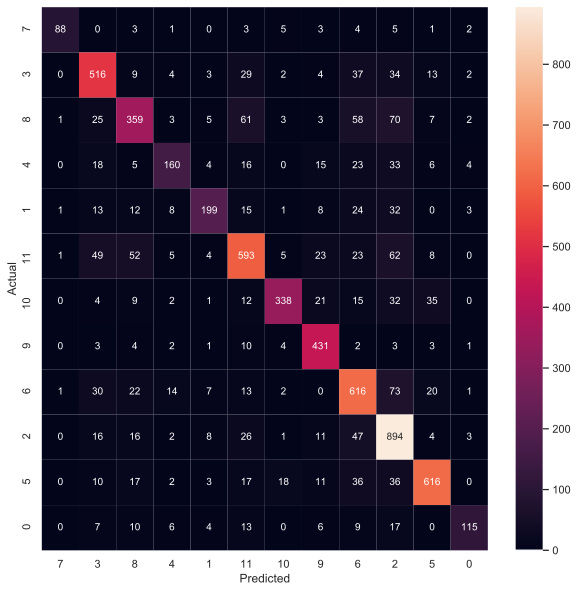

In [42]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_val, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [43]:
from sklearn import metrics
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.77      0.85       115
           1       0.75      0.79      0.77       653
          10       0.69      0.60      0.64       597
          11       0.77      0.56      0.65       284
           2       0.83      0.63      0.72       316
           3       0.73      0.72      0.73       825
           4       0.89      0.72      0.80       469
           5       0.80      0.93      0.86       464
           6       0.69      0.77      0.73       799
           7       0.69      0.87      0.77      1028
           8       0.86      0.80      0.83       766
           9       0.86      0.61      0.72       187

    accuracy                           0.76      6503
   macro avg       0.79      0.73      0.76      6503
weighted avg       0.76      0.76      0.76      6503



# For Prediction on test dataset

In [30]:
data_xtest.head()

,text
0,tvletwgzkrqvuhtwamuluhpkskpmpmiwtvuhamqvmviwlr...
1,qvmvuhskleenmvviengzxyuhqvmvamguuhrakrpmsauhul...
2,twamuhulenamuluhskvienuhqgdftwmvmkletwulvimvuh...
3,sooatwqvvitwqvvipmviuhoaampmpmmwuhuhraulvikrpm...
4,lepmuhpmdfuluhtwletwdfuhtwletwamguuhuhraezpmpm...


In [31]:
labels.head()

0    7
1    3
2    8
3    3
4    4
Name: label, dtype: object

In [32]:
model.fit(train_tfidf, labels)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
y_pred = model.predict(test_tfidf)
y_pred[:5]

array(['6', '11', '8', '8', '8'], dtype=object)

In [34]:
print(y_pred.shape)

(3000,)


In [35]:
prediction_df=pd.DataFrame(model._predict_proba_lr(test_tfidf), columns=model.classes_)
prediction_df[:5]

,0,1,10,11,2,3,4,5,6,7,8,9
0,0.046502,0.067560,0.100315,0.058970,0.045328,0.092867,0.059165,0.017303,0.172559,0.157366,0.107065,0.074999
1,0.015112,0.109052,0.089270,0.143823,0.085184,0.122652,0.093933,0.125256,0.088872,0.022465,0.075513,0.028867
2,0.022787,0.061235,0.127916,0.064207,0.095962,0.123510,0.109305,0.009936,0.089337,0.123977,0.129095,0.042733
3,0.008821,0.160278,0.040668,0.046496,0.061467,0.078859,0.138017,0.037520,0.152779,0.059903,0.170035,0.045157
4,0.025015,0.061606,0.130654,0.060646,0.094797,0.108149,0.115210,0.027675,0.102119,0.080289,0.137671,0.056169


In [36]:
prediction_df["sum"]=prediction_df.sum(axis=1)
prediction_df.head()

,0,1,10,11,2,3,4,5,6,7,8,9,sum
0,0.046502,0.067560,0.100315,0.058970,0.045328,0.092867,0.059165,0.017303,0.172559,0.157366,0.107065,0.074999,1.0
1,0.015112,0.109052,0.089270,0.143823,0.085184,0.122652,0.093933,0.125256,0.088872,0.022465,0.075513,0.028867,1.0
2,0.022787,0.061235,0.127916,0.064207,0.095962,0.123510,0.109305,0.009936,0.089337,0.123977,0.129095,0.042733,1.0
3,0.008821,0.160278,0.040668,0.046496,0.061467,0.078859,0.138017,0.037520,0.152779,0.059903,0.170035,0.045157,1.0
4,0.025015,0.061606,0.130654,0.060646,0.094797,0.108149,0.115210,0.027675,0.102119,0.080289,0.137671,0.056169,1.0


In [37]:
accuracy_value_class=prediction_df.max(axis=1)

In [38]:
df_submit=pd.DataFrame(y_pred, columns=["predicted_class"])
df_submit["probability"]=accuracy_value_class
df_submit.head()

,predicted_class,probability
0,6,1.0
1,11,1.0
2,8,1.0
3,8,1.0
4,8,1.0
